In [1]:
# Download the dataset

# !mkdir -p data/spam_data
# !ls data
# !wget https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2
# !wget https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2
# !wget https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2
# !wget https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2
# !wget https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2
#
# !tar xvjf 20030228_easy_ham_2.tar.bz2
# !tar xvjf 20030228_easy_ham.tar.bz2
# !tar xvjf 20030228_hard_ham.tar.bz2
# !tar xvjf 20030228_spam.tar.bz2
# !tar xvjf 20050311_spam_2.tar.bz2
#
# !mv easy_ham data/spam_data
# !mv easy_ham_2 data/spam_data
# !mv hard_ham data/spam_data
# !mv spam data/spam_data
# !mv spam_2 data/spam_data

In [2]:
# Download the glove embedding
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# !python -m gensim.scripts.glove2word2vec -i glove.6B.300d.txt -o glove.6B.300d.word2vec.txt

In [14]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

# For file processing
import os
import glob
import email
import json
import csv

# For modeling
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\59384\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\59384\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Define the file path

path = 'data/spam_data/'
easy_ham_paths = glob.glob(path+'easy_ham/*')
easy_ham_2_paths = glob.glob(path+'easy_ham_2/*')
hard_ham_paths = glob.glob(path+'hard_ham/*')
spam_paths = glob.glob(path+'spam/*')
spam_2_paths = glob.glob(path+'spam_2/*')

In [3]:
# Getting path for dataset
non_spam_path = easy_ham_paths + easy_ham_2_paths + hard_ham_paths
spam_path = spam_paths+spam_2_paths

print(f'Number of non-spam file: {len(non_spam_path)}')
print(f'Number of spam file: {len(spam_path)}')

# Expected:
# Number of non-spam file: 4153
# Number of spam file: 1898

In [68]:
# Data Extraction:

non_spam_sentences = []
spam_sentences = []
non_spam_labels = []
spam_labels = []
count = 0

# Extract the body content for non-spam message
for path in non_spam_path:
    file = open(path, encoding="utf8", errors='ignore')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True).decode()
                non_spam_sentences.append(body)
                non_spam_labels.append(1)
                count+=1
    except Exception as e:
        print(e)
# Extract the body content for spam message
for path in spam_path:
    file = open(path, encoding="utf8", errors='ignore')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True).decode()
                spam_sentences.append(body)
                spam_labels.append(0)
                count+=1
    except Exception as e:
        print(e)

# Expect: the number of spam_sentences == number of spam_labels
print('\n')
print(f'number of spam_sentences: {len(spam_sentences)}')
print(f'number of spam_labels: {len(spam_labels)}')
print(f'number of non_spam_sentences: {len(non_spam_sentences)}')
print(f'number of non_spam_labels: {len(non_spam_labels)}')
# Inspect the message content
print(f"Non-Spam sample: \n{non_spam_sentences[0]}")


'utf-8' codec can't decode byte 0xb4 in position 93: invalid start byte
'utf-8' codec can't decode byte 0xe8 in position 565: invalid continuation byte
'utf-8' codec can't decode byte 0xe9 in position 2073: invalid continuation byte
'utf-8' codec can't decode byte 0xe9 in position 1965: invalid continuation byte
'utf-8' codec can't decode byte 0xe9 in position 1456: invalid continuation byte
'utf-8' codec can't decode byte 0xe9 in position 1457: invalid continuation byte
'utf-8' codec can't decode byte 0xab in position 2130: invalid start byte
'utf-8' codec can't decode byte 0xb7 in position 1139: invalid start byte
'utf-8' codec can't decode byte 0xe9 in position 1652: invalid continuation byte
'utf-8' codec can't decode byte 0xab in position 1056: invalid start byte
'utf-8' codec can't decode byte 0xab in position 367: invalid start byte
'utf-8' codec can't decode byte 0xab in position 454: invalid start byte
'utf-8' codec can't decode byte 0xe9 in position 1452: invalid continuation

In [24]:
# Remove stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [25]:
#----------------------Testing the cleaning operation on single sample--------------------
msg = spam_sentences[0]
# The upper and lower case should have no impact to the result(neg/pos), so we should convert all chars to lower case, to reduce the overhead of traning process.
msg.lower()
# Using regex to remove any not-chars or \', hyperlinks, emails addr, and same header information
pattern = '[^a-zA-Z\']|\_+|http\S+|\S*@\S*\s?|Date:.*|From:.*|Message.*'
replace = " "
msg = re.sub(pattern, replace, msg).strip()
# Calling re.sub again to remove those redundant whitespace
msg = re.sub('[\r\n\t ]+', replace, msg).strip()
# Remove the any word in stopwords from msg (Those words has no semantic meaning to our model, so we should remove them to reduce the training overhead)
msg = msg.split(' ')
msg = [word for word in msg if word not in stopwords]
msg = " ".join(msg)
msg

"Fight The Risk Cancer Slim Down Guaranteed lose lbs days Get Child Support You Deserve Free Legal Advice Join Web's Fastest Growing Singles Community Start Your Private Photo Album Online Have Wonderful Day Offer Manager PrizeMama If wish leave list please use link Irish Linux Users' Group un subscription information List maintainer"

In [26]:
#----------------------Applying the cleaning operation on all trainign data --------------------
def msg_cleaning(msg):
    # The upper and lower case should have no impact to the result(neg/pos), so we should convert all chars to lower case, to reduce the overhead of traning process.
    msg.lower()
    # Using regex to remove any not-chars or \', hyperlinks, emails addr, and same header information
    pattern = '[^a-zA-Z\']|\_+|http\S+|\S*@\S*\s?|Date:.*|From:.*|Message.*'
    replace = " "
    msg = re.sub(pattern, replace, msg).strip()
    # Calling re.sub again to remove those redundant whitespace
    msg = re.sub('[\r\n\t ]+', replace, msg).strip()
    # Remove the any word in stopwords from msg (Those words has no semantic meaning to our model, so we should remove them to reduce the training overhead)
    msg = msg.split(' ')
    msg = [word for word in msg if word not in stopwords]
    msg = " ".join(msg)
    return msg


In [27]:
# Process the data in the word-by-word fasion: Spcifically, for each word, if it's in the set of stopwords, remove it.
count = 0
for idx, msg in enumerate(spam_sentences):
    spam_sentences[idx] = msg_cleaning(msg)
for idx, msg in enumerate(non_spam_sentences):
    non_spam_sentences[idx] = msg_cleaning(msg)

print('\n')
print(f'number of spam_sentences: {len(spam_sentences)}')
print(f'number of spam_labels: {len(spam_labels)}')
print(f'number of non_spam_sentences: {len(non_spam_sentences)}')
print(f'number of non_spam_labels: {len(non_spam_labels)}')
# Now the msg looks much more clean, let's begin the Tokenization process.



number of spam_sentences: 970
number of spam_labels: 970
number of non_spam_sentences: 4035
number of non_spam_labels: 4035


In [34]:
# Inspect the message content
# print(f"Non-Spam sample: \n{non_spam_sentences[0]}")
print(f"Spam sample: \n{spam_sentences[0]}")

Spam sample: 
Fight The Risk Cancer Slim Down Guaranteed lose lbs days Get Child Support You Deserve Free Legal Advice Join Web's Fastest Growing Singles Community Start Your Private Photo Album Online Have Wonderful Day Offer Manager PrizeMama If wish leave list please use link Irish Linux Users' Group un subscription information List maintainer


In [47]:
# Define the variables
vocab_size = 2000 # Size of word corpus
embedding_dim = 16 # dimension of output vector
max_length = 400 # Maximum length of token
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<ooV>'
training_portion = .8
train_size = 0

non_spam_train_size = int(len(non_spam_labels) * training_portion)
# Split the trainign and testing dataset
x_train = non_spam_sentences[:non_spam_train_size]
y_train = non_spam_labels[:non_spam_train_size]
x_test = non_spam_sentences[non_spam_train_size:]
y_test = non_spam_labels[non_spam_train_size:]
print("Expected the number of len(non_spam_labels) equals to the sum of len(train_labels)+len(valid_labels)")
print(f'Expected {len(y_train)}+{len(y_test)}=={len(non_spam_labels)}')

spam_train_size = int(len(spam_labels) * training_portion)
x_train += spam_sentences[:spam_train_size]
y_train += spam_labels[:spam_train_size]
x_test += spam_sentences[spam_train_size:]
y_test += spam_labels[spam_train_size:]

train_size = non_spam_train_size+spam_train_size
print('\n')
print(f'number of x_train: {len(x_train)}')
print(f'number of y_train: {len(y_train)}')
print(f'number of x_test: {len(x_test)}')
print(f'number of y_test: {len(y_test)}')



Expected the number of len(non_spam_labels) equals to the sum of len(train_labels)+len(valid_labels)
Expected 3228+807==4035


number of x_train: 4004
number of y_train: 4004
number of x_test: 1001
number of y_test: 1001


In [48]:
# Inspect the message content
print(f"Non-Spam sample: \n{non_spam_sentences[0]}")
# print(f"Spam sample: \n{spam_sentences[0]}")

Non-Spam sample: 
I can't reproduce error For repeatable like every time without fail This debug log pick happening Pick It exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequence mercury exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequence mercury Ftoc PickMsgs hit Marking hits tkerror syntax error expression int Note I run pick command hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace sequence mercury hit That's hit comes obviously The version nmh I'm using delta pick version pick nmh compiled fuchsia cs mu OZ AU Sun Mar ICT And relevant part mh profile delta mhparam pick seq sel list Since pick command works sequence actually one explicit command line search popup one comes mh profile get created kre ps still using version code form day ago I haven't able reach cvs repository today local routing issue I think Exmh workers mailing list


In [51]:
## Process word by word
# def remove_null(datas,labels):
#     not_null_idx = [i for i,o in enumerate(datas) if o is not None]
#     return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]
# x_train,y_train = remove_null(x_train,y_train)
# x_test,y_test = remove_null(x_test,y_test)

print('\n')
print(f'number of x_train: {len(x_train)}')
print(f'number of y_train: {len(y_train)}')
print(f'number of x_test: {len(x_test)}')
print(f'number of y_test: {len(y_test)}')



number of x_train: 4004
number of y_train: 4004
number of x_test: 1001
number of y_test: 1001


In [50]:
# Convert to numpy array
train_sentences, train_labels = np.array(x_train), np.array(y_train)
valid_sentences, valid_labels = np.array(x_test), np.array(y_test)

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(valid_sentences))
print(len(valid_labels))

# Expected output (if training_portion=.8)
# 4004
# 4004
# 4004
# 1001
# 1001

4004
4004
4004
1001
1001


In [59]:

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("\nWord Index = " , word_index)
print(f"\nSequences[0]: {train_sentences[0]}")
print(f"Sequences[0]: {train_sequences[0]}")
print("Padded Sequences: ")
print(train_padded)


Word Index =  {'<ooV>': 1, 'i': 2, 'e': 3, 'b': 4, 'c': 5, 'f': 6, 'd': 7, 'not': 8, 'the': 9, 'will': 10, 'br': 11, 'can': 12, 'list': 13, 'mv': 14, 'one': 15, 'font': 16, 'a': 17, 'this': 18, 'no': 19, 'just': 20, 'get': 21, 'email': 22, 'to': 23, 'p': 24, 'you': 25, 'people': 26, 'like': 27, 'time': 28, 'use': 29, 'mail': 30, 'now': 31, 'free': 32, 'nbsp': 33, 'new': 34, 'information': 35, 'if': 36, "don't": 37, 'make': 38, 'linux': 39, 'mailing': 40, 'we': 41, 'it': 42, 'wrote': 43, 'us': 44, 'on': 45, 'also': 46, "i'm": 47, 'in': 48, 'td': 49, 'work': 50, 'please': 51, 'size': 52, 'want': 53, 'way': 54, 'first': 55, 'razor': 56, 'name': 57, 'spam': 58, 'and': 59, 'know': 60, 'group': 61, 'send': 62, 'money': 63, 'message': 64, 'see': 65, 'your': 66, 'think': 67, 'said': 68, 'even': 69, 'need': 70, 'for': 71, 'using': 72, 'net': 73, 's': 74, 'color': 75, 'much': 76, 'good': 77, 'well': 78, 'business': 79, 'address': 80, 'may': 81, 'many': 82, "'": 83, 'order': 84, 'line': 85, 'sub

In [60]:
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)
print(f"\nSequences[0]: {valid_sentences[0]}")
print(f"Sequences[0]: {valid_sequences[0]}")
print("Padded Sequences: ")
print(valid_padded)


Sequences[0]: In message dimebox Hal DeVore writes On Wed Jul Chris Chris Garrigues wrote Chris Am I one typing control L main Chris window causes error Getting copy I haven't updated CVS since May sometime It's well Christer Sys admin MEDIC WWW Email Phone I fought loa loa won I fought loa loa won Dave Aronsson s r Exmh workers mailing list
Sequences[0]: [48, 64, 1, 1, 1, 574, 45, 812, 740, 651, 651, 1875, 43, 651, 408, 2, 15, 1, 612, 97, 819, 651, 606, 1, 307, 331, 421, 2, 668, 1478, 665, 151, 81, 1, 160, 78, 1, 1, 1841, 1, 481, 22, 137, 2, 1, 1, 1, 968, 2, 1, 1, 1, 968, 889, 1, 74, 188, 146, 1122, 40, 13]
Padded Sequences: 
[[   0    0    0 ... 1122   40   13]
 [   0    0    0 ... 1125    1    1]
 [   0    0    0 ... 1326    1 1616]
 ...
 [   1    1  902 ...    1    1    1]
 [   0    0    0 ...   35   13  107]
 [  14    3  341 ...    6    1  330]]


In [61]:
# Convering the label to numpy array
training_labels_final = np.array(train_labels)
testing_labels_final = np.array(valid_labels)
print('\n')
print(f'number of x_train: {len(train_padded)}')
print(f'number of y_train: {len(training_labels_final)}')
print(f'number of x_test: {len(valid_padded)}')
print(f'number of y_test: {len(testing_labels_final)}')



number of x_train: 4004
number of y_train: 4004
number of x_test: 1001
number of y_test: 1001


In [62]:
#-----------------Baseline model----------------

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 16)           32000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400, 128)          31488     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 65,569
Trainable params: 65,569
Non-trainable params: 0
__________________________________________________

In [63]:
# Training the models
history = model.fit(
    train_padded,
    training_labels_final,
    batch_size=512,
    epochs=20,
    validation_data=(valid_padded, testing_labels_final)
)
model.save("spam_filter_v2.h5")

Train on 4004 samples, validate on 1001 samples
Epoch 1/20
4004/4004 [==============================] - 8s 2ms/sample - loss: 0.6651 - acc: 0.7920 - val_loss: 0.6296 - val_acc: 0.8062
Epoch 2/20
4004/4004 [==============================] - 1s 154us/sample - loss: 0.6009 - acc: 0.8062 - val_loss: 0.5570 - val_acc: 0.8062

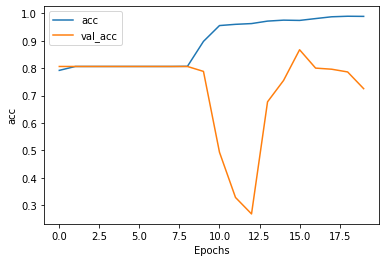

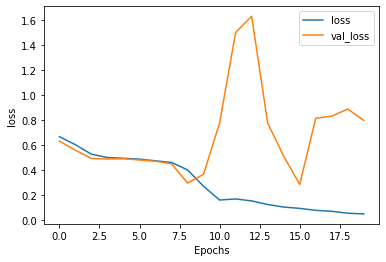

In [65]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [67]:
# Making Predictions
import numpy as np
import keras
# from keras.preprocessing import image
root_dir = "./test_data"
# Process file path
file_names = os.listdir(root_dir)
for file_name in file_names:
    dir = f"{root_dir}/{file_name}"
    file = open(path, encoding="utf8", errors='ignore')
    msg = email.message_from_file(file)
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            x = part.get_payload(decode=True).decode()
            x = np.expand_dims(x, axis=0) # Return View of `a` with the number of dimensions increased.
            data = np.vstack([x])

            # Making prediction
            classes = model.predict(x)
            print(f"Image class: {classes[0]}")
            if classes[0]>0.5:
              print(file_name + " is a spam")
            else:
              print(file_name + " is a non_spam")


ValueError: Error when checking input: expected embedding_1_input to have shape (400,) but got array with shape (1,)

#---------------- Model v2: with pretrained model----------------



In [34]:
from nltk.tokenize import word_tokenize

# Play around with Word2vector

c:\users\59384\anaconda3\envs\facecourse-py3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [43]:
from gensim.models import KeyedVectors

w2v = KeyedVectors.load_word2vec_format('glove.6B.300d.word2vec.txt',binary=False)

In [ ]:
## Use Glove Pretrain
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [50]:
maxlen = 2000
max_features = 50000

In [51]:
EMBEDDING_FILE = 'glove.6B.300d.txt'
tokenizer = Tokenizer(num_words=max_features)

In [52]:
tokenizer.fit_on_texts(x_train)

In [53]:
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features = pad_sequences(x_train_features,maxlen=maxlen)
x_test_features = pad_sequences(x_test_features,maxlen=maxlen)

In [54]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 6148: character maps to <undefined>

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
model.layers[1].trainable = False

In [ ]:
history = model.fit(x_train_features,y_train, batch_size=512, epochs=20, 
          validation_data=(x_test_features, y_test))

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Neural Network w Embedding From Scratch

In [ ]:
# Neural Network w Embedding From Scratch

In [ ]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [ ]:
tokenizer = Tokenizer(num_words=max_feature)

In [ ]:
tokenizer.fit_on_texts(x_train)

In [ ]:
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

In [ ]:
embed_size = 100

inp = Input(shape=(max_len,))
x = Embedding(max_feature, embed_size)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
## Neural Network